100%|██████████| 170M/170M [00:02<00:00, 74.1MB/s]


Epoch [1/20], Loss: 0.0291
Epoch [2/20], Loss: 0.0195
Epoch [3/20], Loss: 0.0177
Epoch [4/20], Loss: 0.0168
Epoch [5/20], Loss: 0.0162
Epoch [6/20], Loss: 0.0158
Epoch [7/20], Loss: 0.0155
Epoch [8/20], Loss: 0.0151
Epoch [9/20], Loss: 0.0148
Epoch [10/20], Loss: 0.0147
Epoch [11/20], Loss: 0.0145
Epoch [12/20], Loss: 0.0142
Epoch [13/20], Loss: 0.0142
Epoch [14/20], Loss: 0.0140
Epoch [15/20], Loss: 0.0138
Epoch [16/20], Loss: 0.0138
Epoch [17/20], Loss: 0.0137
Epoch [18/20], Loss: 0.0136
Epoch [19/20], Loss: 0.0135
Epoch [20/20], Loss: 0.0135


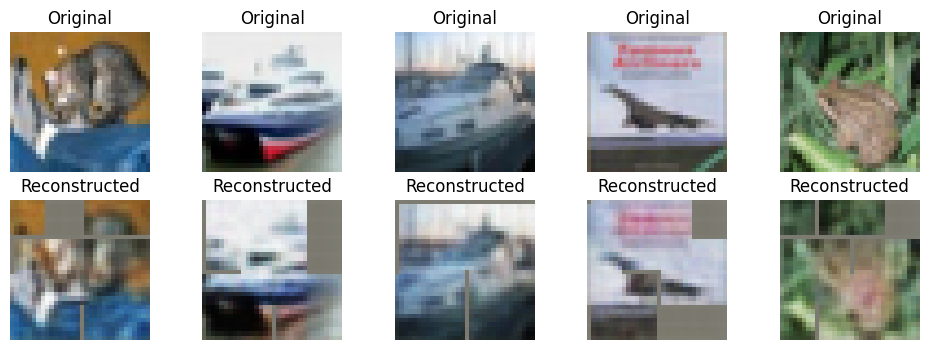

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset
transform = transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

# Masked Autoencoder Class
class MaskedAutoencoder(nn.Module):
    def __init__(self, mask_ratio=0.5):
        super(MaskedAutoencoder, self).__init__()
        self.mask_ratio = mask_ratio

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),   # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 4x4
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def mask_feature_map(self, features):
        B, C, H, W = features.shape
        total = H * W
        num_mask = int(total * self.mask_ratio)

        for b in range(B):
            mask_indices = random.sample(range(total), num_mask)
            for idx in mask_indices:
                h = idx // W
                w = idx % W
                features[b, :, h, w] = 0
        return features

    def forward(self, x):
        encoded = self.encoder(x)
        masked = self.mask_feature_map(encoded.clone())
        decoded = self.decoder(masked)
        return decoded, encoded

# Train Masked Autoencoder
mcae_model = MaskedAutoencoder(mask_ratio=0.5).to(device)
mcae_optim = optim.Adam(mcae_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 20
mcae_loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for imgs, _ in trainloader:
        imgs = imgs.to(device)
        recon, _ = mcae_model(imgs)
        loss = criterion(recon, imgs)
        mcae_optim.zero_grad()
        loss.backward()
        mcae_optim.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(trainloader)
    mcae_loss_list.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Visualize

def show_images(original, reconstructed, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(np.transpose(original[i], (1, 2, 0)))
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

mcae_model.eval()
with torch.no_grad():
    for data in testloader:
        imgs, _ = data
        imgs = imgs.to(device)
        recon, _ = mcae_model(imgs)
        break

show_images(imgs.cpu(), recon.cpu())


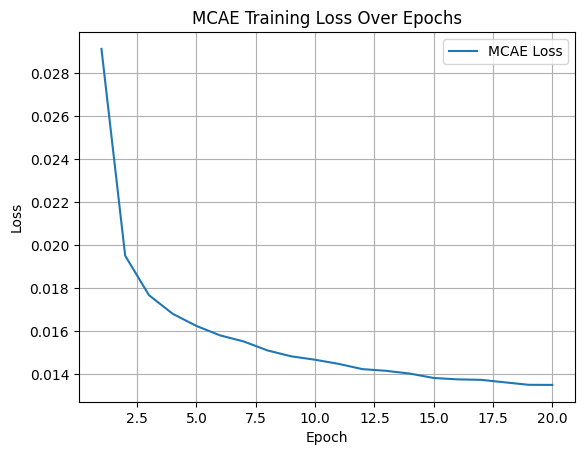

In [2]:
plt.plot(range(1, num_epochs+1), mcae_loss_list, label="MCAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MCAE Training Loss Over Epochs")
plt.grid()
plt.legend()
plt.show()


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Extract embeddings
def extract_embeddings(model, loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            _, enc = model(imgs)
            embeddings.append(enc.view(enc.size(0), -1).cpu())
            labels.append(lbls)
    return torch.cat(embeddings), torch.cat(labels)

train_emb, train_labels = extract_embeddings(mcae_model, trainloader)
test_emb, test_labels = extract_embeddings(mcae_model, testloader)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(train_emb, train_labels)
preds = clf.predict(test_emb)
acc = accuracy_score(test_labels, preds)
print("Linear classification accuracy (frozen MCAE embeddings):", acc)


Linear classification accuracy (frozen MCAE embeddings): 0.436


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


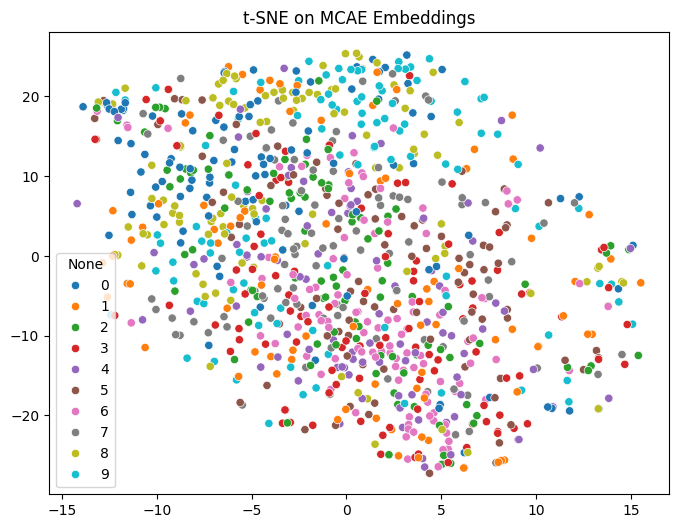

In [5]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
reduced = tsne.fit_transform(test_emb[:1000])
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=test_labels[:1000], palette="tab10", legend='full')
plt.title("t-SNE on MCAE Embeddings")
plt.show()


In [9]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def overlay_heatmaps(n=6, mask_ratio=0.4):
    model.eval()
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:n].to(device)
    imgs.requires_grad = True

    recon, _, _ = model(imgs, mask_ratio)
    loss = criterion(recon, imgs)
    loss.backward()

    grads = imgs.grad.abs().detach().cpu()
    imgs_cpu = imgs.detach().cpu()

    fig, axs = plt.subplots(1, n, figsize=(3 * n, 3))
    for i in range(n):
        img = imgs_cpu[i].permute(1, 2, 0).numpy()
        grad = grads[i].mean(0).numpy()  # Channel-wise mean
        grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)

        axs[i].imshow(img)
        axs[i].imshow(grad, cmap='hot', alpha=0.5)  # Overlay
        axs[i].axis("off")

    plt.suptitle("Overlay of Original Images and Saliency Heatmaps")
    plt.tight_layout()
    plt.show()


In [11]:
mask_ratios = [0.3, 0.5, 0.7]
models = {}
for ratio in mask_ratios:
    print(f"\nTraining with mask ratio: {ratio}")
    model = MaskedAutoencoder(mask_ratio=ratio).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        ...
    models[ratio] = model



Training with mask ratio: 0.3

Training with mask ratio: 0.5

Training with mask ratio: 0.7


In [16]:
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            _, encoded = model(imgs)
            features.append(encoded.view(encoded.size(0), -1).cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

# Extract
train_feats, train_lbls = extract_features(mcae_model, trainloader)
test_feats, test_lbls = extract_features(mcae_model, testloader)

# Train linear classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000).fit(train_feats, train_lbls)
accuracy = clf.score(test_feats, test_lbls)
print("Linear Classifier Accuracy:", accuracy)


Linear Classifier Accuracy: 0.4328


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


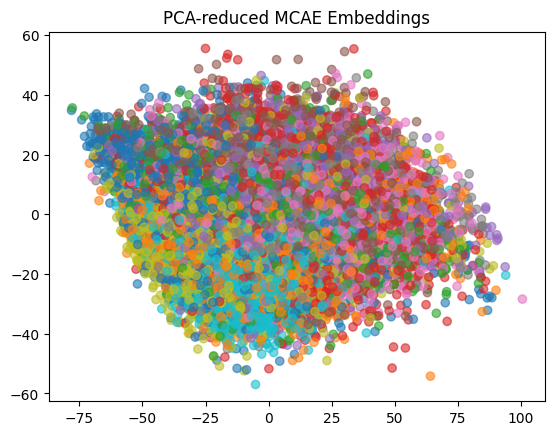

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

reduced = PCA(n_components=2).fit_transform(train_feats)
plt.scatter(reduced[:, 0], reduced[:, 1], c=train_lbls, cmap='tab10', alpha=0.6)
plt.title("PCA-reduced MCAE Embeddings")
plt.show()


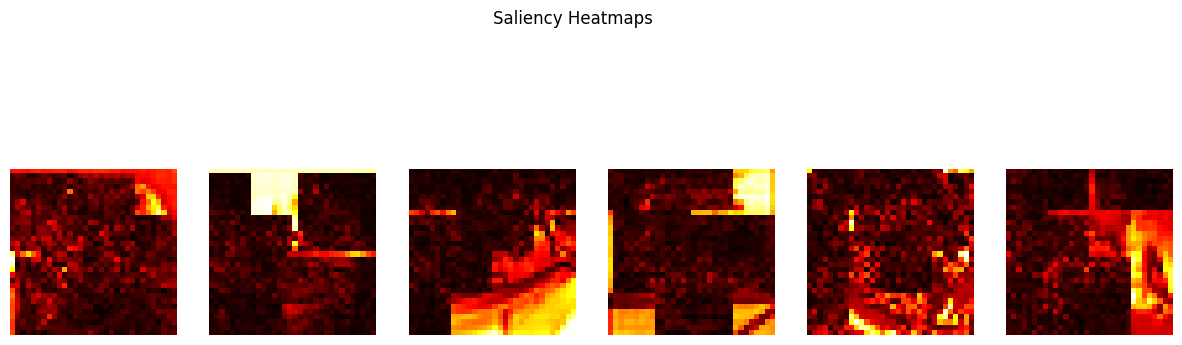

In [14]:
def generate_saliency_heatmaps(model, dataloader, n=6):
    model.eval()
    imgs, _ = next(iter(dataloader))
    imgs = imgs[:n].to(device)
    imgs.requires_grad_()

    recon, _ = model(imgs)
    loss = criterion(recon, imgs)
    loss.backward()

    saliency = imgs.grad.data.abs().sum(dim=1).cpu().numpy()  # [n, H, W]

    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        axes[i].imshow(saliency[i], cmap='hot')
        axes[i].axis("off")
    plt.suptitle("Saliency Heatmaps")
    plt.show()

generate_saliency_heatmaps(mcae_model, testloader)
